In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../Kaggle_dataset/AADR1.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,31.650000,31.650000,31.500000,31.500000,30.171495,1500
1,1/3/2013,31.530001,31.730000,31.430000,31.639999,30.305590,3400
2,1/4/2013,31.490000,31.700001,31.490000,31.549999,30.219389,2600
3,1/7/2013,31.730000,31.799999,31.730000,31.799999,30.458843,600
4,1/8/2013,31.440001,31.629999,31.440001,31.450001,30.123606,5500


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: 2526.480043.3, cost: -4659.254395, total money: 109.800058
epoch: 20, total rewards: 2796.450029.3, cost: -7495.279785, total money: 326.960054
epoch: 30, total rewards: 3014.940024.3, cost: -13386.549805, total money: 488.950030
epoch: 40, total rewards: 350.959984.3, cost: -28734.757812, total money: 6538.229988
epoch: 50, total rewards: 156.769951.3, cost: -32454.044922, total money: 9171.719952
epoch: 60, total rewards: 386.169987.3, cost: -31163.941406, total money: 8368.249985
epoch: 70, total rewards: 338.179974.3, cost: -31103.939453, total money: 8000.219974
epoch: 80, total rewards: 258.479988.3, cost: -31636.708984, total money: 8821.199989
epoch: 90, total rewards: 241.729984.3, cost: -32284.517578, total money: 9154.439987
epoch: 100, total rewards: 296.169987.3, cost: -32150.373047, total money: 8958.839989
epoch: 110, total rewards: 263.620010.3, cost: -32214.980469, total money: 9269.210010
epoch: 120, total rewards: 76.249996.3, cost: -32243.2

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 6: buy 1 unit at price 31.900000, total balance 9968.100000
day 9: buy 1 unit at price 32.169998, total balance 9935.930002
day 11, sell 1 unit at price 32.599998, investment 2.194354 %, total balance 9968.530001,
day 12, sell 1 unit at price 32.430000, investment 0.808213 %, total balance 10000.960001,
day 14: buy 1 unit at price 32.740002, total balance 9968.219999
day 15, sell 1 unit at price 32.430000, investment -0.946858 %, total balance 10000.650000,
day 17: buy 1 unit at price 32.750000, total balance 9967.900000
day 18, sell 1 unit at price 32.750000, investment 0.000000 %, total balance 10000.650000,
day 19: buy 1 unit at price 32.799999, total balance 9967.850000
day 20, sell 1 unit at price 32.980000, investment 0.548781 %, total balance 10000.830000,
day 21: buy 1 unit at price 33.500000, total balance 9967.330000
day 22, sell 1 unit at price 33.119999, investment -1.134332 %, total balance 10000.449999,
day 24: buy 1 unit at price 33.400002, total balance 9967.049997


day 285, sell 1 unit at price 37.000000, investment -1.359633 %, total balance 9993.310022,
day 286: buy 1 unit at price 37.000000, total balance 9956.310022
day 287, sell 1 unit at price 37.959999, investment 2.594592 %, total balance 9994.270021,
day 288: buy 1 unit at price 38.049999, total balance 9956.220022
day 291, sell 1 unit at price 38.459999, investment 1.077529 %, total balance 9994.680021,
day 296: buy 1 unit at price 38.380001, total balance 9956.300020
day 297: buy 1 unit at price 37.830002, total balance 9918.470018
day 299: buy 1 unit at price 37.990002, total balance 9880.480017
day 300, sell 1 unit at price 37.990002, investment -1.016153 %, total balance 9918.470018,
day 301, sell 1 unit at price 37.509998, investment -0.845899 %, total balance 9955.980017,
day 303, sell 1 unit at price 37.730000, investment -0.684396 %, total balance 9993.710016,
day 305: buy 1 unit at price 37.169998, total balance 9956.540018
day 306, sell 1 unit at price 37.299999, investment 0.

day 469, sell 1 unit at price 37.709999, investment 4.315346 %, total balance 9781.200022,
day 471: buy 1 unit at price 37.540001, total balance 9743.660021
day 474, sell 1 unit at price 37.730000, investment 4.370672 %, total balance 9781.390020,
day 476, sell 1 unit at price 37.599998, investment 0.615466 %, total balance 9818.990019,
day 477, sell 1 unit at price 38.290001, investment 2.461873 %, total balance 9857.280020,
day 479: buy 1 unit at price 38.240002, total balance 9819.040018
day 480: buy 1 unit at price 38.380001, total balance 9780.660017
day 481, sell 1 unit at price 38.380001, investment 2.702709 %, total balance 9819.040018,
day 484, sell 1 unit at price 38.230000, investment 2.356094 %, total balance 9857.270017,
day 485, sell 1 unit at price 38.169998, investment 2.195448 %, total balance 9895.440016,
day 486: buy 1 unit at price 38.270000, total balance 9857.170015
day 488: buy 1 unit at price 38.049999, total balance 9819.120016
day 489, sell 1 unit at price 37.

day 707, sell 1 unit at price 37.860001, investment 3.896822 %, total balance 9446.200002,
day 709, sell 1 unit at price 38.840000, investment 7.144828 %, total balance 9485.040003,
day 710: buy 1 unit at price 38.430000, total balance 9446.610002
day 715: buy 1 unit at price 39.119999, total balance 9407.490003
day 716: buy 1 unit at price 39.119999, total balance 9368.370004
day 717: buy 1 unit at price 38.919998, total balance 9329.450006
day 718, sell 1 unit at price 38.820000, investment 5.603921 %, total balance 9368.270006,
day 719, sell 1 unit at price 38.480000, investment 4.593636 %, total balance 9406.750006,
day 720: buy 1 unit at price 38.270000, total balance 9368.480005
day 723: buy 1 unit at price 37.990002, total balance 9330.490003
day 724: buy 1 unit at price 37.970001, total balance 9292.520002
day 725, sell 1 unit at price 38.119999, investment 4.438353 %, total balance 9330.640001,
day 726, sell 1 unit at price 38.500000, investment 6.148331 %, total balance 9369.

day 885: buy 1 unit at price 39.189999, total balance 9653.999990
day 888: buy 1 unit at price 39.779999, total balance 9614.219992
day 891, sell 1 unit at price 40.599998, investment 6.060605 %, total balance 9654.819990,
day 894, sell 1 unit at price 40.599998, investment 6.645650 %, total balance 9695.419988,
day 896: buy 1 unit at price 40.590000, total balance 9654.829988
day 900: buy 1 unit at price 40.590000, total balance 9614.239988
day 901: buy 1 unit at price 40.590000, total balance 9573.649988
day 902, sell 1 unit at price 40.590000, investment 5.128204 %, total balance 9614.239988,
day 903: buy 1 unit at price 40.580002, total balance 9573.659986
day 905: buy 1 unit at price 40.580002, total balance 9533.079985
day 906: buy 1 unit at price 40.500000, total balance 9492.579985
day 907: buy 1 unit at price 40.500000, total balance 9452.079985
day 908, sell 1 unit at price 40.389999, investment 3.378551 %, total balance 9492.469984,
day 909: buy 1 unit at price 41.200001, to

day 1195: buy 1 unit at price 55.599998, total balance 8622.389994
day 1196: buy 1 unit at price 55.750000, total balance 8566.639994
day 1199, sell 1 unit at price 56.590000, investment 17.871281 %, total balance 8623.229994,
day 1200: buy 1 unit at price 56.709999, total balance 8566.519995
day 1201, sell 1 unit at price 56.709999, investment 19.188728 %, total balance 8623.229994,
day 1202, sell 1 unit at price 56.939999, investment 19.171202 %, total balance 8680.169992,
day 1203, sell 1 unit at price 56.759998, investment 18.151535 %, total balance 8736.929991,
day 1205: buy 1 unit at price 57.299999, total balance 8679.629991
day 1206, sell 1 unit at price 57.630001, investment 18.726823 %, total balance 8737.259992,
day 1208: buy 1 unit at price 57.200001, total balance 8680.059992
day 1209, sell 1 unit at price 56.910000, investment 18.488447 %, total balance 8736.969992,
day 1211: buy 1 unit at price 57.900002, total balance 8679.069990
day 1212: buy 1 unit at price 58.430000,

day 1359, sell 1 unit at price 58.279999, investment -6.856322 %, total balance 8648.129995,
day 1361, sell 1 unit at price 57.630001, investment -6.898224 %, total balance 8705.759996,
day 1362, sell 1 unit at price 57.660000, investment -8.008935 %, total balance 8763.419996,
day 1364, sell 1 unit at price 58.669998, investment -6.262984 %, total balance 8822.089994,
day 1365, sell 1 unit at price 59.410000, investment -5.443263 %, total balance 8881.499994,
day 1366, sell 1 unit at price 60.070000, investment -3.284497 %, total balance 8941.569994,
day 1367: buy 1 unit at price 59.049999, total balance 8882.519995
day 1369, sell 1 unit at price 59.299999, investment -6.333916 %, total balance 8941.819994,
day 1370, sell 1 unit at price 59.070000, investment -5.518235 %, total balance 9000.889994,
day 1371: buy 1 unit at price 58.470001, total balance 8942.419992
day 1372, sell 1 unit at price 58.209999, investment -1.389124 %, total balance 9000.629991,
day 1373: buy 1 unit at price

day 1530, sell 1 unit at price 44.320000, investment -14.357489 %, total balance 9139.350008,
day 1531, sell 1 unit at price 44.520000, investment -8.545604 %, total balance 9183.870008,
day 1532, sell 1 unit at price 44.369999, investment -9.670196 %, total balance 9228.240007,
day 1533: buy 1 unit at price 44.639999, total balance 9183.600008
day 1534: buy 1 unit at price 44.270000, total balance 9139.330007
day 1536: buy 1 unit at price 44.119999, total balance 9095.210009
day 1537, sell 1 unit at price 43.930000, investment -9.905657 %, total balance 9139.140009,
day 1538, sell 1 unit at price 44.610001, investment -2.683245 %, total balance 9183.750009,
day 1539, sell 1 unit at price 44.599998, investment -2.620089 %, total balance 9228.350008,
day 1540, sell 1 unit at price 45.009998, investment -5.042201 %, total balance 9273.360006,
day 1541: buy 1 unit at price 45.430000, total balance 9227.930006
day 1542, sell 1 unit at price 45.529999, investment -6.084985 %, total balance 

day 1704, sell 1 unit at price 47.610001, investment -4.301506 %, total balance 9538.100000,
day 1706, sell 1 unit at price 48.230000, investment -0.618173 %, total balance 9586.330000,
day 1707, sell 1 unit at price 48.290001, investment -1.126125 %, total balance 9634.620001,
day 1709, sell 1 unit at price 48.369999, investment -0.616395 %, total balance 9682.990000,
day 1710: buy 1 unit at price 48.660000, total balance 9634.330000
day 1711: buy 1 unit at price 48.430000, total balance 9585.899999
day 1714, sell 1 unit at price 48.450001, investment -1.061876 %, total balance 9634.350000,
day 1716, sell 1 unit at price 49.630001, investment -0.100643 %, total balance 9683.980001,
day 1717: buy 1 unit at price 49.700001, total balance 9634.280001
day 1719, sell 1 unit at price 50.560001, investment 3.926002 %, total balance 9684.840002,
day 1720: buy 1 unit at price 50.430000, total balance 9634.410002
day 1725: buy 1 unit at price 50.040001, total balance 9584.370001
day 1726, sell 

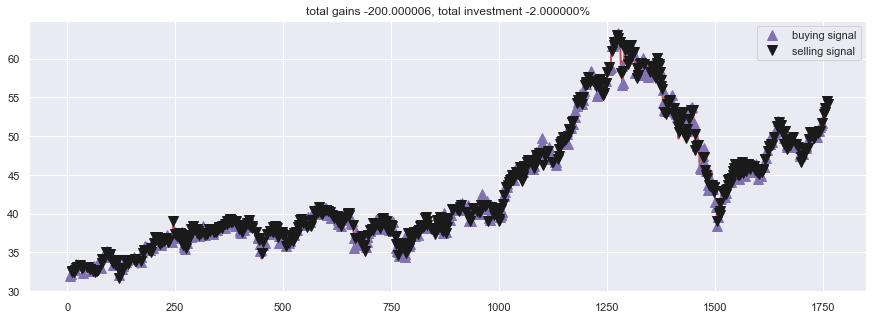

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()